# 概要

20211004 

本コードは画像AIのための池の画像のファイルリスト作成コードである<br>



# ライブラリのインポート

## Loggerのインポート

`MyLogger`は自作のロガークラスであり、`util/MyLogger.py`で実装されている。<br>

In [1]:
%matplotlib inline

from IPython.display import display

import argparse
import os
import sys
import re
import cv2
import shutil
import time as tm
import datetime as dt
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
from tqdm import tqdm
from pathlib import Path
from PIL import Image


from utils import MyLogger

sns.set()

# Configファイルのロード

設定情報やハイパーパラメータをjsonからロードする。<br>
引数ではないが、利便性からargsに格納する。<br>

In [2]:
config_path = "configs/check_image"
# config_filename = "east_3-2_final_settling_tank"
config_filename = "east_3-2_final_settling_tank_201811"
# config_filename = "east_3-2_final_settling_tank_201812"

args = pd.read_json(Path(config_path, f"{config_filename}.json"), typ = 'series', encoding = "utf-8")
display(args)

seed                                                       20190517
filelist_dir      results/create_filelist/east_3-2_final_settlin...
outdir_org        E:/image_ai2021/hiroshima_seibu/east_3-2_final...
outdir_crop       E:/image_ai2021/hiroshima_seibu/east_3-2_final...
start_index                                      2018-11-1 00:00:00
end_index                                       2018-11-30 23:59:59
crop_lat_n                                                      400
crop_lat_s                                                      900
crop_lon_w                                                      400
crop_lon_e                                                      900
resize_height                                                   256
resize_width                                                    256
illum_low_lim                                                    85
illum_high_lim                                                  100
dtype: object

# アウトプットディレクトリの生成


In [3]:
outdir_log = Path("results", "check_image", config_filename)
outdir_log.mkdir(parents=True, exist_ok = True)
args.to_csv(Path(outdir_log, config_filename + ".csv"))

# Loggerの設定

MyLoggerクラスによって汎用ロガーを作成する。<br>
標準出力にINFO情報までを出力し、`root`と`filename`に指定したファイルにDEBUG情報まで出力する。<br>
moduleNmaeは`__name__`とすることでmainを指定できる。

In [4]:
path_log = Path('logs/')
path_log.mkdir(parents = True, exist_ok = True)

from logging import ERROR, INFO
ml = MyLogger(root = path_log,
              filename = "check_image.log",
              stream_level = INFO,
              moduleName = __name__)

logger = ml.getModuleLogger()

logger.info("start script")
logger.info(f"config file name :{config_filename}")

[2021-10-05 18:13:37,850 | __main__ | INFO] start script
[2021-10-05 18:13:37,862 | __main__ | INFO] config file name :east_3-2_final_settling_tank_201811


In [5]:
filelist_path = Path(args.filelist_dir, "file_list.csv")

file_list = pd.read_csv(filelist_path, index_col = "datetime", parse_dates = True)

display(file_list.shape)
display(file_list.index.dtype)
display(file_list.dtypes)
display(file_list.head())
display(file_list.tail())
display(file_list.info())

(209569, 1)

dtype('<M8[ns]')

filename    object
dtype: object

,filename
datetime,
2018-03-02 10:40:10,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-08-21 09:10:46,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-08-21 09:10:56,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-08-21 09:11:06,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-08-21 09:11:16,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...


,filename
datetime,
2019-12-05 13:16:18,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2019-12-05 13:16:28,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2019-12-05 13:16:38,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2019-12-05 13:16:48,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2019-12-05 13:16:58,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 209569 entries, 2018-03-02 10:40:10 to 2019-12-05 13:16:58
Data columns (total 1 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   filename  209569 non-null  object
dtypes: object(1)
memory usage: 3.2+ MB


None

In [6]:
start_datetime = dt.datetime.strptime(args.start_index, '%Y-%m-%d %H:%M:%S')
file_list = file_list[file_list.index >= start_datetime]

end_datetime = dt.datetime.strptime(args.end_index, '%Y-%m-%d %H:%M:%S')
file_list = file_list[file_list.index <= end_datetime]


display(file_list.shape)    
display(file_list.head())
display(file_list.tail())

(6500, 1)

,filename
datetime,
2018-11-20 13:24:06,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-20 13:24:16,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-20 13:24:26,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-20 13:24:36,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-20 13:24:46,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...


,filename
datetime,
2018-11-30 23:54:52,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-30 23:55:02,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-30 23:55:12,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-30 23:55:22,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...
2018-11-30 23:55:32,\\10.101.65.115\広島西部\002_広島西部水資源再生センター\02_data...


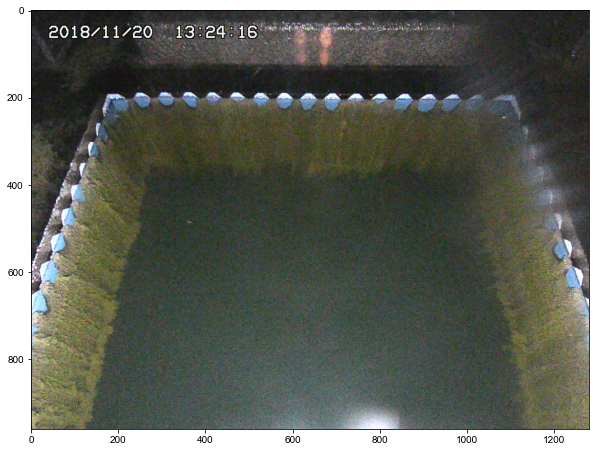

In [7]:
check_num = 1

tmp_datetime = file_list.iloc[check_num].index
tmp_filename = file_list.iloc[check_num].filename

# image = cv2.imread(file_list.iloc[check_num].filename.as_posix(), cv2.IMREAD_UNCHANGED)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_pil = Image.open(file_list.iloc[check_num].filename)
image = np.asarray(image_pil)

fig = plt.figure(figsize=(10, 10))
with plt.style.context('default') as st:
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image)

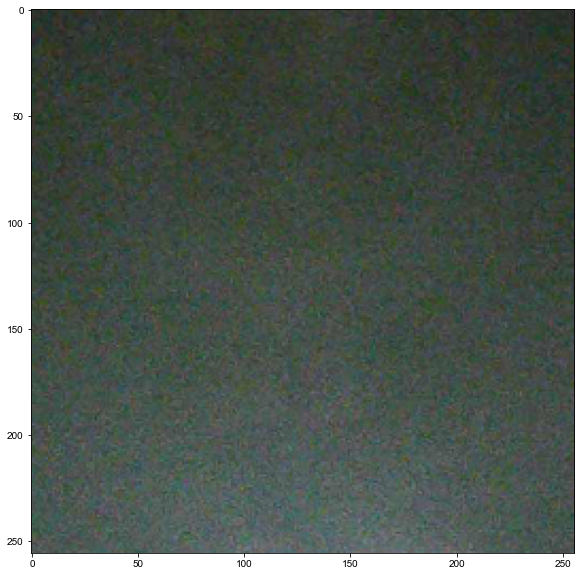

In [8]:
#infanviewとはｘｙ逆
#xが縦（上から）、yが横（ひだりから）
image_trim = image[args.crop_lat_n:args.crop_lat_s, args.crop_lon_w:args.crop_lon_e]
# image_trim = image[400:1000, 400:900]
image_resize = cv2.resize(image_trim, (args.resize_height, args.resize_width))

fig = plt.figure(figsize=(10, 10))
with plt.style.context('default') as st:
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image_resize)

In [9]:
# hsv変換
image_hsv = cv2.cvtColor(image_resize, cv2.COLOR_RGB2HSV)
image_v = image_hsv[:, :, 2]
illum = image_v.mean()

display(illum)

76.24813842773438

In [10]:
t_s = tm.time()

illumdir = Path(outdir_log, "illum")
illumdir.mkdir(parents=True, exist_ok=True)


illum_list_path = Path(illumdir, "illum_list.csv")

if illum_list_path.exists() :
    illum_list = pd.read_csv(illum_list_path, index_col = "datetime", parse_dates = True)
else :
    illum_list = pd.DataFrame(columns = ["illum"], index = file_list.index)

    for tmp_datetime, tmp_image in tqdm(file_list.sample(n = np.min((file_list.shape[0], 1000))).iterrows()):
#         image = cv2.imread(tmp_image.filename.as_posix(), cv2.IMREAD_UNCHANGED)
        
        image_pil = Image.open(tmp_image.filename)
        image_cv2 = np.asarray(image_pil)
        image = cv2.cvtColor(image_cv2, cv2.COLOR_RGB2BGR)
        
        # 画像ファイルであれば実行        
        if np.all(image != None): 
            #infanviewとはｘｙ逆
            #xが縦（上から）、yが横（ひだりから）
            image_trim = image[args.crop_lat_n:args.crop_lat_s, args.crop_lon_w:args.crop_lon_e]
            image_resize = cv2.resize(image_trim, (args.resize_height, args.resize_width))

            # hsv変換
            image_hsv = cv2.cvtColor(image_resize, cv2.COLOR_BGR2HSV)
            image_v = image_hsv[:, :, 2]
            illum = image_v.mean()
            illum_list.loc[tmp_datetime, "illum"] = illum

    illum_list = illum_list.dropna().astype(np.float32)
    illum_list.to_csv(illum_list_path, float_format="%.3f")

duration = tm.time() - t_s
logger.info("get illum : elapsed time is {:.2f} [s]".format(duration))

[2021-10-05 18:13:43,479 | __main__ | INFO] get illum : elapsed time is 0.17 [s]


C:\Users\0000170039\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


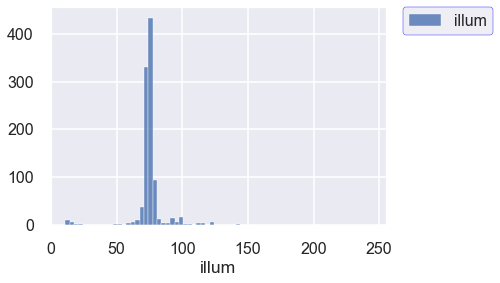

In [11]:
fig = plt.figure()
with plt.style.context('seaborn-poster') as st:
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(0, 255)
    sns.distplot(illum_list.loc[:, "illum"], label = "illum", kde=False, rug=False, bins=40, hist_kws = {"alpha":0.8}, ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., frameon=True, edgecolor="blue")
    plt.savefig(Path(illumdir, "histgram.png").as_posix(), bbox_inches="tight")

C:\Users\0000170039\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


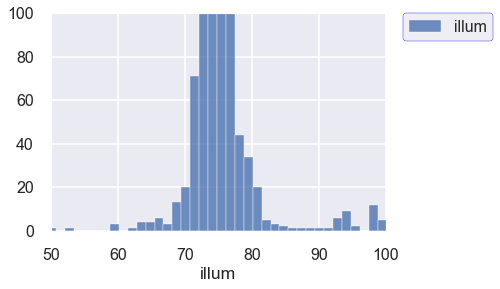

In [12]:
fig = plt.figure()
with plt.style.context('seaborn-poster') as st:
    ax = fig.add_subplot(1,1,1)
    ax.set_xlim(50, 100)
    ax.set_ylim(0, 100)
    sns.distplot(illum_list.loc[:, "illum"], label = "illum", kde=False, rug=False, bins=100, hist_kws = {"alpha":0.8}, ax = ax)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., frameon=True, edgecolor="blue")
    plt.savefig(Path(illumdir, "histgram_detail.png").as_posix(), bbox_inches="tight")

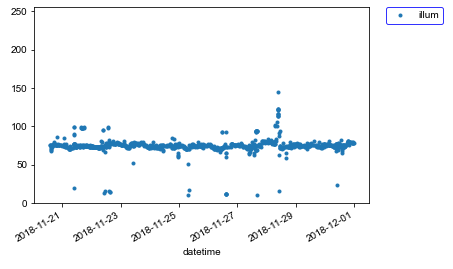

In [13]:
fig = plt.figure()
with plt.style.context('default') as st:
    ax = fig.add_subplot(1,1,1)
    ax.set_ylim(0, 255)
    illum_list.plot(ax = ax, marker = ".", lw = 0)
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0., frameon=True, edgecolor="blue")
    plt.savefig(Path(illumdir, "hist_time.png").as_posix(), bbox_inches="tight")

'truth_count : 39'

Timestamp('2018-11-27 16:25:32')

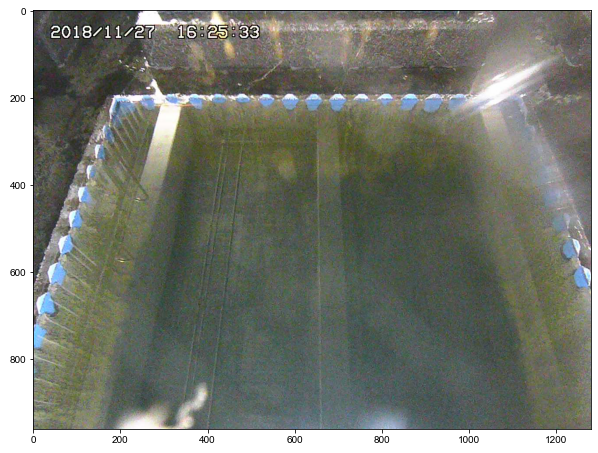

In [14]:
# tmp_low_lim =50
# tmp_high_lim =70
tmp_low_lim =85
tmp_high_lim =100

flag = (illum_list.illum >= tmp_low_lim) & (illum_list.illum <= tmp_high_lim)
truth_count = flag.sum()
display("truth_count : {}".format(truth_count))

tmp_index =illum_list[flag].sample().index[0]
display(tmp_index)

# image = cv2.imread(file_list.loc[tmp_index].filename.as_posix(), cv2.IMREAD_UNCHANGED)
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

image_pil = Image.open(file_list.loc[tmp_index].filename)
image = np.asarray(image_pil)

fig = plt.figure(figsize=(10, 10))
with plt.style.context('default') as st:
    ax = fig.add_subplot(1,1,1)
    ax.imshow(image)
    plt.savefig(Path(illumdir, "sample_image.png").as_posix(), bbox_inches="tight")